In [1]:
import os
import copy
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import random
import sys
import time
from importlib import reload

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix

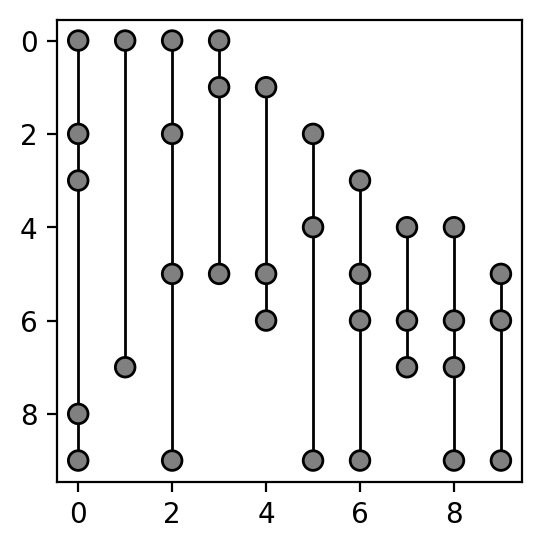

In [2]:
n_rows = 10
n_cols = 10
I = ut.generate_incidence_matrix(n_rows=n_rows, 
                              n_cols=n_cols, 
                              order=3, 
                              min_count=3)


node_params = {
    's' : 200,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 1,
    'zorder' : 1,
}
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
plt2.plot_incidence(ut.sort_by_lowest_index(I),
                    node_color='grey',
                    line_color='k',
                    node_params=node_params,
                    line_params=line_params)


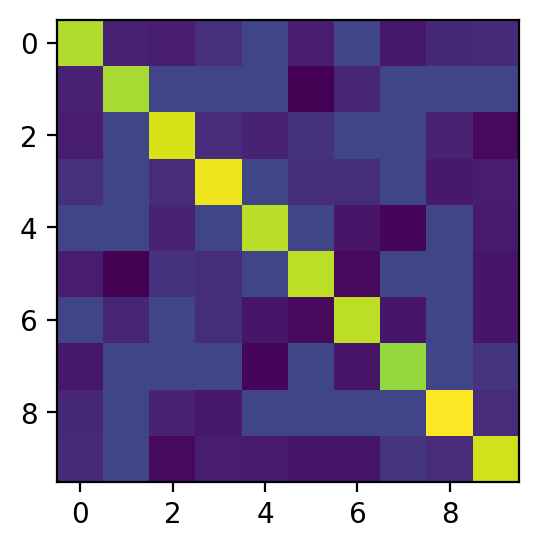

In [3]:
def higher_order_laplacian(H):
    """Calculates the higher-order Laplacian from an incidence matrix.

    Args:
        H: The incidence matrix (NumPy array).

    Returns:
        The higher-order Laplacian matrix (NumPy array).
    """
    
    D = np.diag(np.sum(H, axis=1))  # Degree matrix
    E = np.diag(np.sum(H, axis=0))  # Hyperedge size matrix

    # Use np.linalg.pinv for numerically stable pseudo-inverse
    L = D - np.dot(H, np.dot(np.linalg.pinv(E), H.T)) 
    return L


def higher_order_normalized_laplacian(H):
    """Calculates the higher-order Laplacian from an incidence matrix.

    Args:
        H: The incidence matrix (NumPy array).

    Returns:
        L: The higher-order Laplacian matrix (NumPy array).
    """

    # Degree and size matrices
    node_degrees = np.sum(H, axis=1)
    hyperedge_sizes = np.sum(H, axis=0)

    # Normalized degree matrix
    Dhat = np.diag(1 / np.sqrt(node_degrees))
    Dhat[node_degrees == 0] = 0  # Handle potential zero degrees

    # Identity matrix
    I = np.identity(Dhat.shape[0])

    # Matrix calculations 
    E_inv = np.linalg.inv(np.diag(hyperedge_sizes))  
    intermediate = np.dot(H, np.dot(E_inv, H.T))

    # Higher-order Laplacian
    L = I - np.dot(Dhat, np.dot(intermediate, Dhat)) 

    return L


def get_fiedler_number(L):
    """Calculates the Fiedler number (algebraic connectivity) of a graph Laplacian matrix.

    The Fiedler number is the second-smallest eigenvalue of the Laplacian matrix.

    Args:
        L: The Laplacian matrix (NumPy array).

    Returns:
        The Fiedler number (float).
    """

    eigenvalues, _ = np.linalg.eigh(L)
    fiedler_number = eigenvalues[1]  # Second-smallest eigenvalue
    return fiedler_number
    

L = higher_order_normalized_laplacian(I)
plt.imshow(L)

Text(0, 0.5, 'Fiedler Number Diff')

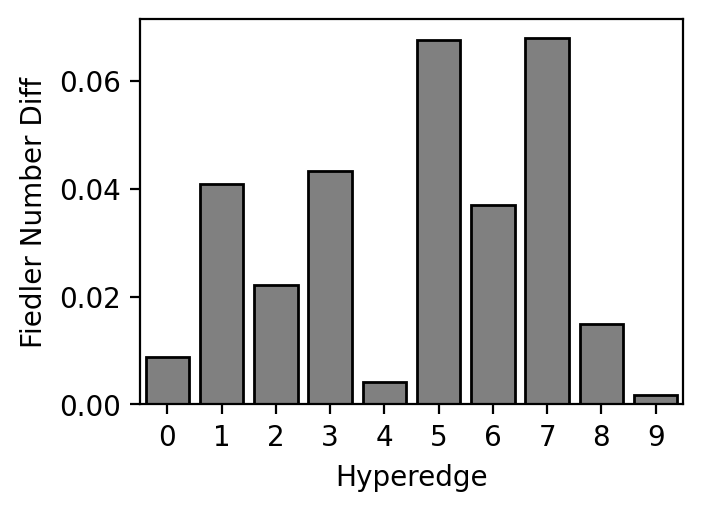

In [4]:
def calculate_fiedler_diffs(I):
    """Calculates Fiedler number differences for each hyperedge in an incidence matrix.

    Args:
        I: The incidence matrix (pandas DataFrame).

    Returns:
        A pandas DataFrame with columns:
            * column: The name of the hyperedge.
            * fiedler: The Fiedler number after removing the hyperedge.
            * fiedler_diff: The absolute difference from the base Fiedler number.
    """

    fiedler_base = get_fiedler_number(higher_order_normalized_laplacian(I))

    def calculate_for_hyperedge(hyperedge):
        tmp = I.drop(hyperedge, axis=1)
        L = higher_order_normalized_laplacian(tmp)
        L = np.nan_to_num(L, 0)
        fiedler = get_fiedler_number(L)
        return {
            'column': hyperedge,
            'fiedler': fiedler,
            'fiedler_diff': np.abs(fiedler_base - fiedler)
        }
    
    results = [calculate_for_hyperedge(hyperedge) for hyperedge in I.columns]
    return pd.DataFrame(results) 


res = calculate_fiedler_diffs(I)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

sns.barplot(data=res, 
            x='column',
            y='fiedler_diff',
            ec='k',
            color='grey')

plt.xlabel('Hyperedge')
plt.ylabel('Fiedler Number Diff')

# how does this scale

In [5]:
reload(ut)

# first, keep the nodes fixed
n_rows = 10

res = []
for n_cols in range(10, 1000, 100):
    I = ut.generate_incidence_matrix(n_rows=n_rows, 
                                     n_cols=n_cols, 
                                     order=3, 
                                     min_count=3)
    
    start = time.time()
    _ = calculate_fiedler_diffs(I)
    end = time.time()
    
    row = {
        'n_cols' : n_cols,
        'start' : start,
        'end' : end,
        'elapsed' : end - start,
    }
    res.append(row)
    
    
res = pd.DataFrame(res)
res.head()

,n_cols,start,end,elapsed
0,10,1.714750e+09,1.714750e+09,0.020497
1,110,1.714750e+09,1.714750e+09,0.253717
2,210,1.714750e+09,1.714750e+09,0.712934
3,310,1.714750e+09,1.714750e+09,1.787390
4,410,1.714750e+09,1.714750e+09,3.727946


<Axes: xlabel='n_cols', ylabel='elapsed'>

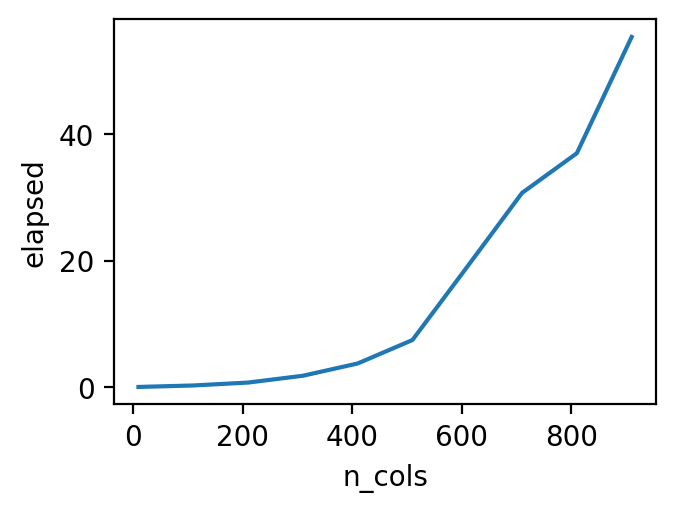

In [6]:
sns.lineplot(data=res,
             x='n_cols',
             y='elapsed')

In [7]:
def get_func(x, y):
    coeffs = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
    func = lambda x: np.exp(coeffs[1]) * np.exp(coeffs[0] * x)
    return func
    
x = res['n_cols'].values
y = res['elapsed'].values

func = get_func(x, y)
time_est = func(3000)
print(f"{time_est / 60 :.3f} mins")
# func = lambda x:  np.exp(coeffs[0]) * np.exp(coeffs[1] * x)
# func(100)

24525.860 mins


In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# test on sample

In [ ]:
# load the population data

fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_pore_c/chr1_1000000_incidence.csv"

# randomly sample columns to load faster
sample_size = 1000
n_cols = 122676
cols = list(range(n_cols))
rand_cols = np.random.choice(cols, sample_size, replace=False)
rand_cols = [str(x) for x in rand_cols]
rand_cols.insert(0, 'bin')
df = pd.read_csv(fpath, usecols=rand_cols)

df = df.set_index('bin')
print(f"{df.shape=}")
df.head()

In [ ]:
break

In [ ]:
%timeit
res = calculate_fiedler_diffs(df)

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2.5

sns.barplot(data=res, 
            x='column',
            y='fiedler_diff',
            ec='k',
            color='grey')

plt.xlabel('Hyperedge')
plt.ylabel('Fiedler Number Diff')
plt.xticks([])